In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import quad
import matplotlib.pyplot as plt

In [2]:
class GaussianApproximator:
    def __init__(self, initial_params, zeta, phi_sf_func):
        self.n_gaussians = len(initial_params) // 2
        self.zeta = zeta
        self.phi_sf = phi_sf_func
        self.params = initial_params
        self.bounds = [(0, 10), (-1, 1)] * self.n_gaussians  # パラメータの範囲

    @staticmethod
    def phi_g1s(alpha, r):
        return (2 * alpha / np.pi) ** (3 / 4) * np.exp(-alpha * r**2)

    @staticmethod
    def phi_g2p(alpha, r):
        return (128 * alpha**5 / np.pi**3) ** (1 / 4) * r * np.exp(-alpha * r**2)

    def phi_approx(self, params, r):
        sum_phi = 0
        for i in range(self.n_gaussians):
            alpha = params[2 * i]
            c = params[2 * i + 1]
            sum_phi += c * self.phi_g2p(alpha, r)
        return sum_phi

    def integrand(self, r, params):
        return (
            np.abs(self.phi_approx(params, r) - self.phi_sf(self.zeta, r)) ** 2
            * 4
            * np.pi
            * r**2
            / 3
        )

    def objective_function(self, params):
        integral, error = quad(self.integrand, 0, np.inf, args=(params,))
        return integral

    def normalization_constraint(self, params):
        integral, error = quad(
            lambda r: self.phi_approx(params, r) ** 2 * 4 * np.pi * r**2 / 3, 0, np.inf
        )
        return integral - 1

    def optimize(self):
        constraint = {"type": "eq", "fun": self.normalization_constraint}
        result = minimize(
            self.objective_function,
            self.params,
            bounds=self.bounds,
            constraints=constraint,
        )
        return result

In [3]:
def phi_1s(zeta_1, r):
    return (zeta_1**3 / np.pi) ** 0.5 * np.exp(-zeta_1 * r)


def phi_2s(zeta_2, r):
    return (zeta_2**5 / (3 * np.pi)) ** 0.5 * r * np.exp(-zeta_2 * r)


def phi_2p(zeta_2, r):
    return (zeta_2**5 / np.pi) ** 0.5 * r * np.exp(-zeta_2 * r)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.0030947032555210282
       x: [ 1.069e-01  6.713e-01  4.324e-01  4.523e-01]
     nit: 20
     jac: [ 4.084e-03  2.877e-03 -1.012e-03  2.579e-03]
    nfev: 110
    njev: 20


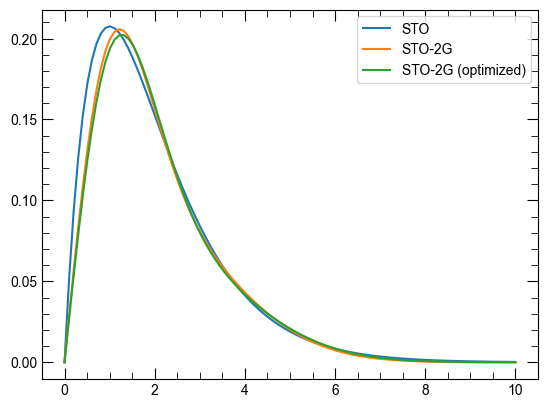

In [8]:
approximator = GaussianApproximator([0.5, 0.5, 0.9, 0.5], 1, phi_2p)
optimized_params = approximator.optimize()
print(optimized_params)
fig, ax = plt.subplots()
r = np.linspace(0, 10, 100)
y = phi_2p(1, r)
y2 = approximator.phi_approx(optimized_params.x, r)
y3 = approximator.phi_approx([9.74545e-2, 6.12820e-1, 3.84244e-1, 5.11541e-1], r)
ax.plot(r, y, label="STO")
ax.plot(r, y2, label="STO-2G")
ax.plot(r, y3, label="STO-2G (optimized)")
ax.legend()

In [9]:
quad(
    lambda r: approximator.phi_approx(optimized_params.x, r) ** 2
    * 4
    * np.pi
    * r**2
    / 3,
    0,
    np.inf,
)

(1.0000000253139678, 1.378309637751286e-09)

In [11]:
quad(
    lambda r: approximator.phi_approx(
        [9.74545e-2, 6.12820e-1, 3.84244e-1, 5.11541e-1], r
    )
    ** 2
    * 4
    * np.pi
    * r**2
    / 3,
    0,
    np.inf,
)

(1.0000009036172492, 9.648059000581869e-09)